In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
#Read data
file_paths = [
    r"pop_mvmd.csv",
    r"propi.csv",
    r"ptax.csv",
    r"ratesav.csv",
    r"rcon.csv",
    r"rconhh_09Q3.csv",
    r"rcons.csv",
    r"rconsnp_09Q3.csv",
    r"rex.csv",
    r"rg.csv",
    r"rgf.csv",
    r"rgsl.csv",
    r"rimp.csv",
    r"rinvbf.csv",
    
    r"rinvrsid.csv",
    r"rnx.csv",
    r"ruc_md.csv",
    r"wsd.csv",
    r"cpi_md94Q3.csv",
    r"gdp.csv",
    r"hstarts_mvmd.csv",
    r"ipt_mvmd.csv",
    r"lfc_mvmd.csv",
    r"lfpart_mvmd.csv",
    r"m1_md.csv",
    r"oli.csv",
    r"oph.csv",
    r"oph_98Q4.csv",
    r"p.csv",
    r"pinti.csv",
    r"pintpaid.csv"
]
dataframes = ["rinvchi"]
for file_path in file_paths:
    try:
        # Extracting filename without extension
        file_name = file_path.split("\\")[-1].split(".")[0]
        # Reading CSV into DataFrame with variable name same as filename
        globals()[file_name] = pd.read_csv(file_path, encoding="utf-8")
        
        # Printing name and dimensions
        #print("Name:", file_name)
        #print("Dimensions:", globals()[file_name].shape)
        dataframes.append(file_name)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

rinvchi = pd.read_excel("rinvchiQvQd.xlsx")

In [10]:
monthly_dataframes = []

for file_name in dataframes:
    # Check if the number of rows in the DataFrame is greater than 308
    if len(globals()[file_name]) > 308:
        # Append the file name to the list
        monthly_dataframes.append(file_name)
def convert (df):
    quarterly_data = df[df['DATE'].str.endswith(('03', '06', '09', '12'))].reset_index(drop=True)

    #print(quarterly_data.shape)
    return quarterly_data

for file_name in monthly_dataframes:
    globals()[file_name] = convert(globals()[file_name])

ipt_mvmd = ipt_mvmd.iloc[-308:].reset_index(drop=True)

Extract data col from each df according to forcast point 

In [12]:
def get_month_code(lookup):
    suffix = lookup[-2:]
    month_mapping = {
        "Q1": "M3",
        "Q2": "M6",
        "Q3": "M9",
        "Q4": "M12"
    }
    if suffix in month_mapping:
        return lookup[:2] + month_mapping[suffix]
    else:
        return None



def data_extract(lookup):
    result_df = pd.DataFrame() 
    gdp_columns = [col for col in gdp if col.endswith(lookup)]
    if gdp_columns:
        # Extract the column along with its header
        result_df = pd.concat([result_df, gdp["DATE"]], axis=1)
        #result_df = pd.concat([result_df, gdp[gdp_columns[0]]], axis=1)



    #other predictor
    for name in dataframes: 
        df= globals()[name]  
        df_q = [col for col in df if col.endswith(lookup)]
        if df_q:
            result_df = pd.concat([result_df, df[df_q[0]]], axis=1)
        else:
            mlook = get_month_code(lookup)
            df_q = [col for col in df if col.endswith(mlook)]
            if df_q:
             result_df = pd.concat([result_df, df[df_q[0]]], axis=1)
    return result_df


In [197]:
#Add lags
#use lagged observations (e.g. t-x to t-12) as input variables to forecast the current time step (t) , where x is the number of steps ahead
def series_to_supervised(data, col_name, n_in=1, steps = 1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list, NumPy array, or pandas DataFrame/Series.
    Col_name: name of column to transform
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1
    if isinstance(data, list) or isinstance(data, np.ndarray):
        n_vars = 1
    elif isinstance(data, pd.DataFrame):
        n_vars = data.shape[1]
    elif isinstance(data, pd.Series):
        n_vars = 1
        data = pd.DataFrame(data)
    else:
        raise ValueError("Unsupported data type. Please provide data as a list, NumPy array, or pandas DataFrame/Series.")

    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, steps-1,-1):
        cols.append(df.shift(i))
        names += [(f'{col_name}(t-{i})')]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    #agg.dropna(subset=[agg.columns[-1]], inplace=True)


    return agg





def test_col(data, col_name, n_in = -12, steps = 1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list, NumPy array, or pandas DataFrame/Series.
    Col_name: name of column to transform
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1
    if isinstance(data, list) or isinstance(data, np.ndarray):
        n_vars = 1
    elif isinstance(data, pd.DataFrame):
        n_vars = data.shape[1]
    elif isinstance(data, pd.Series):
        n_vars = 1
        data = pd.DataFrame(data)
    else:
        raise ValueError("Unsupported data type. Please provide data as a list, NumPy array, or pandas DataFrame/Series.")

    df = pd.DataFrame(data)
    cols, names = list(), list()
    # forecast sequence (t, t+1, ... t+n)
    for i in range(n_in +steps+2 , steps+1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'{col_name}(t)')]
        else:
            names += [(f'{col_name}(t{i})')]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    return agg


Train and Test Data

In [233]:
prediction_array = []

In [234]:
#User inputs
input1 = '2023'
input2 = 'Q1'
input3 = '2Q'

#def random_forest (input1, input2,input3):
lookup = input1[-2:] + input2
step = np.int64(input3[0])


df = data_extract(lookup)
df = df[df.loc[:, df.columns.str.startswith('ROUTPUT')].notna().any(axis=1)]

X_no_lag = df
X_no_lag = X_no_lag.drop(columns=['DATE'])
X_no_lag = X_no_lag.loc[:, ~X_no_lag.columns.duplicated()]


y_no_lag = df.loc[:, df.columns.str.startswith('ROUTPUT')].iloc[:,0]


# Drop NA rows at the bottom of X_no_lag
X_no_lag = X_no_lag.dropna(how='all', axis=0)
# Drop NA rows at the bottom of y_no_lag
y_no_lag = y_no_lag.dropna(how='all')

X_no_lag

,rinvchi23Q1,POP23M3,PROPI23Q1,PTAX23Q1,RATESAV23Q1,ROUTPUT23Q1,rconhh23Q1,RCONS23Q1,rconsnp23Q1,REX23Q1,...,HSTARTS23M3,IPT23M3,LFC23M3,LFPART23M3,M123Q1,OLI23Q1,OPH23Q1,P23Q1,PINTI23Q1,PINTPAID23Q1
1,-4.5,NaN,-8.350172,1.550419,4.9941,-0.270703,NaN,1.443882,NaN,-1.237129,...,NaN,0.000000,NaN,NaN,NaN,-6.124363,0.430858,1.353560,3.390155,0.000000
2,-17.5,NaN,1.785762,1.020417,7.0787,-0.207213,NaN,-0.204997,NaN,-5.216723,...,NaN,0.722025,NaN,NaN,NaN,-7.654008,-1.004985,1.563107,2.197891,10.536052
3,-2.9,NaN,3.193305,5.433435,5.7810,1.553458,NaN,-0.527231,NaN,-12.065601,...,NaN,0.701757,NaN,NaN,NaN,-2.298952,1.308856,2.041543,2.150621,0.000000
4,14.6,0.071057,3.922071,1.904819,6.9077,1.491376,NaN,1.064454,NaN,-4.669618,...,NaN,-1.398624,-0.752943,-0.4837,NaN,1.156082,2.299499,1.139163,1.058211,18.232156
5,27.8,0.067018,9.929822,-11.483926,8.6528,1.639264,NaN,1.556895,NaN,-9.763847,...,NaN,1.369884,1.629091,0.9174,NaN,0.000000,2.003608,1.180762,1.047130,8.004271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,197.6,0.040827,-0.161898,4.106554,7.2842,1.681542,-0.001304,0.866233,1.400135,5.283777,...,3.569752,-0.196271,0.058511,0.0110,0.740850,1.624624,1.089500,1.652068,0.108656,0.602946
300,214.5,0.045561,1.199615,11.417724,4.3187,-0.411217,-0.486996,0.521501,1.236876,-1.174900,...,-3.493055,0.677969,0.267550,0.1383,0.184236,1.650074,-1.559086,1.993016,0.799211,3.713771
301,110.2,0.059145,1.316241,1.357773,3.2143,-0.144653,0.183240,1.115318,-0.253918,3.230125,...,0.828822,-0.288323,-0.168149,-0.1415,-0.345279,0.976283,-0.974991,2.154406,2.237177,6.464499
302,38.7,0.065085,1.519400,1.268384,2.7249,0.798002,0.126067,0.900680,-2.228736,3.405914,...,-2.892903,0.095740,-0.057692,-0.0765,-0.927482,1.231200,0.284952,1.067450,1.711824,13.149323


In [235]:
X_lag = pd.DataFrame()
X_train = pd.DataFrame()
X_test = pd.DataFrame()

X_cols = list(set(X_no_lag.columns.tolist()))

for i in range(len(X_cols)):
    c = X_cols[i]
    try:
        lagged_col = series_to_supervised(X_no_lag[c], c, 12, step)
        X_lag = pd.concat([X_lag, lagged_col], axis=1)


    except Exception as e:
        print(f"Error occurred for column: {c}, Error: {e}")
X_lag = X_lag.dropna(how='all')    



In [236]:
y_train = y_no_lag [step*2:,]
X_train = X_lag.iloc[:-step, :]
X_test = X_lag.iloc[-1:,]


In [223]:
y_train

5      1.639264
6      0.573310
7      0.107716
8     -1.385703
9     -0.342303
         ...   
299    1.681542
300   -0.411217
301   -0.144653
302    0.798002
303    0.712500
Name: ROUTPUT23Q1, Length: 299, dtype: float64

In [237]:
y_test = gdp["ROUTPUT24Q1"].dropna() #use latest data to calculate error
len_test = len(X_lag)+step*2 
y_test= y_test.iloc[len_test-step+1:len_test+1,]
y_test

305    0.510176
306    1.186611
Name: ROUTPUT24Q1, dtype: float64

In [224]:
print("Dimensions of X_train:", X_train.shape)
print("Dimensions of X_test:", X_test.shape)
print("Dimensions of y_train:", y_train.shape)
print("Dimensions of y_test:", y_test.shape)


Dimensions of X_train: (299, 330)
Dimensions of X_test: (1, 330)
Dimensions of y_train: (299,)
Dimensions of y_test: ()


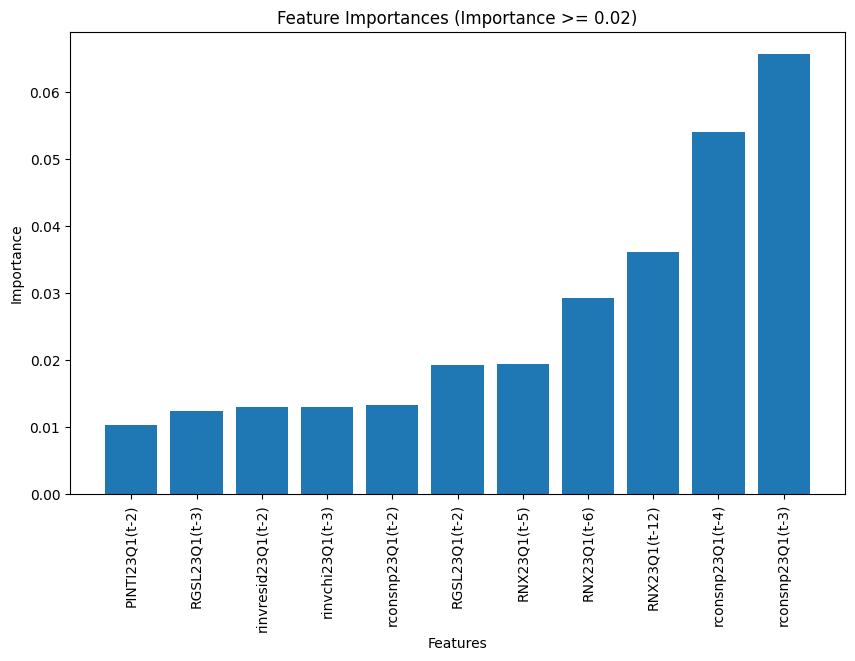

(1,)

In [242]:

train_percentage = 0.8
n_tree = 100

# Fit a Random Forest model
rf_model = RandomForestRegressor(n_estimators= n_tree)
rf_model.fit(X_train, y_train)


# Get feature importances
importances = rf_model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Set threshold for feature importance
threshold = 0.01

# Filter features with importance >= threshold
selected_indices = np.where(importances >= threshold)[0]
selected_importances = importances[selected_indices]
selected_feature_names = [feature_names[i] for i in selected_indices]

# Sort selected features in ascending order of importance
sorted_indices = np.argsort(selected_importances)
sorted_importances = selected_importances[sorted_indices]
sorted_feature_names = [selected_feature_names[i] for i in sorted_indices]

# Plot selected feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Importance >= 0.02)")
plt.bar(range(len(sorted_indices)), sorted_importances, align="center")
plt.xticks(range(len(sorted_indices)), sorted_feature_names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()




predictions = rf_model.predict(X_test)

predictions.shape


The importance of features in a machine learning model, such as a Random Forest, represents the contribution of each feature to the model's predictive performance. It indicates how much each feature influences the model's predictions. Feature importance is a valuable metric for understanding which features are most relevant or influential in making predictions.

In the context of a Random Forest model:

Feature Importance: 
The importance of a feature is typically calculated based on how much the feature reduces impurity in the decision trees within the Random Forest. Features that lead to the greatest decrease in impurity (e.g., Gini impurity or entropy) when used in splitting decisions are considered more important.

Relative Importance: 
Feature importance is usually relative rather than absolute. That means the importance of features is compared within the context of the specific model being trained. Features with higher importance values are relatively more important compared to features with lower values in the same model.

Interpretation: 
Higher feature importance suggests that the feature has a stronger relationship with the target variable and contributes more to the model's predictions. Conversely, lower feature importance indicates that the feature has less influence on the model's predictions.

Usage:
Feature selection: Identifying the most important features for model training and reducing the dimensionality of the dataset.
Model interpretation: Understanding the factors driving the model's predictions and gaining insights into the underlying relationships in the data.
Debugging: Identifying potential issues such as irrelevant or redundant features, data leakage, or biases in the training data.